<a href="https://colab.research.google.com/github/muniappabalaji/TimeSeries/blob/main/Moving_Average_Exponential_Smoothing_GL_Aug2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
import itertools
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.tsa.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

Load the data

In [ ]:
data = pd.read_csv('/content/champagne.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [ ]:
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [ ]:
len(data)

105

Convert Date as date element

In [ ]:
dates = pd.date_range(start = '1964-01-01', freq='MS', periods=len(data))

In [ ]:
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
data.set_index(dates, inplace = True)

In [ ]:
data.head()

,Month,Sales
1964-01-01,1964-01,2815
1964-02-01,1964-02,2672
1964-03-01,1964-03,2755
1964-04-01,1964-04,2721
1964-05-01,1964-05,2946


Seasonal Decompose

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
sales_ts = data['Sales']
sales_ts[0:5]

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


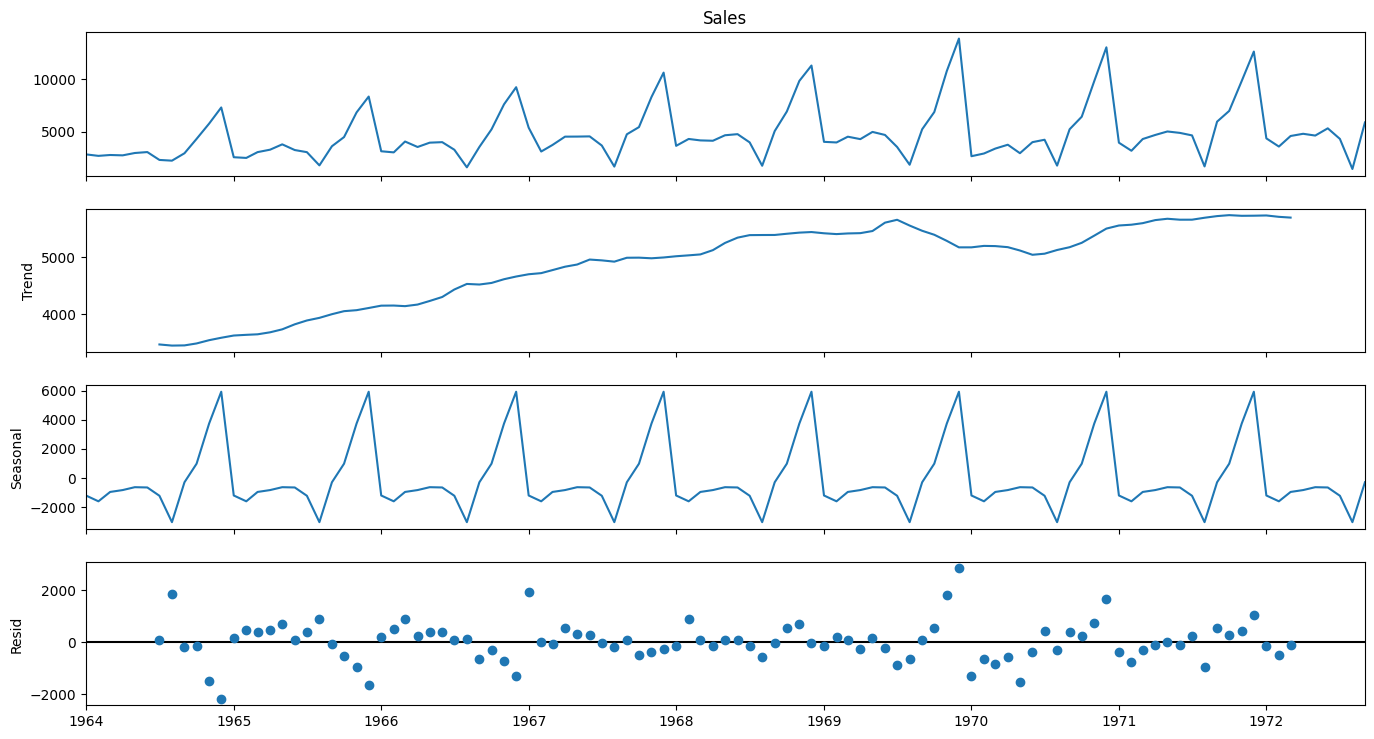

In [ ]:
decomposition = seasonal_decompose(sales_ts)
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

# Modeling

In [ ]:
data = pd.DataFrame(sales_ts.copy())
data.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
train_len = int(np.ceil(len(data)*0.75))
print(train_len)

79


In [ ]:
train=data[0:train_len]
test=data[train_len:]
print('Train Data Length: ', len(train))
print('Test Data Length: ', len(test))

Train Data Length:  79
Test Data Length:  26


Moving Average

In [ ]:
x_train = train.drop('Sales', axis=1)
x_test = test.drop('Sales', axis=1)
y_train = train[['Sales']]
y_test = test[['Sales']]

In [ ]:
df1 = data.copy()

In [ ]:
for i in range(1,12):
  df1['moving_avg_forecast'] = data['Sales'].rolling(i).mean()
  train =df1[0:train_len]
  test = df1[train_len:]
  y_hat_avg = test.copy()
  rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
  abs_error = np.abs(y_test['Sales']- y_hat_avg.moving_avg_forecast)
  actual = y_test['Sales']
  mape = np.round(np.mean(np.abs((actual - y_hat_avg.moving_avg_forecast) / actual)) * 100, 2)
  print('Rolling Window: ', i, 'RMSE: ', rmse, 'MAPE: ', mape)

Rolling Window:  1 RMSE:  0.0 MAPE:  0.0
Rolling Window:  2 RMSE:  1619.8348681269952 MAPE:  28.3
Rolling Window:  3 RMSE:  2259.099344966341 MAPE:  43.91
Rolling Window:  4 RMSE:  2589.3879525382054 MAPE:  50.07
Rolling Window:  5 RMSE:  2811.8374148752464 MAPE:  53.36
Rolling Window:  6 RMSE:  2831.300752266761 MAPE:  53.22
Rolling Window:  7 RMSE:  2824.161842292323 MAPE:  51.07
Rolling Window:  8 RMSE:  2864.4349916719043 MAPE:  51.51
Rolling Window:  9 RMSE:  3004.9476499462316 MAPE:  58.28
Rolling Window:  10 RMSE:  3057.589854393867 MAPE:  58.62
Rolling Window:  11 RMSE:  3046.595428823695 MAPE:  55.81


In [ ]:
df1['moving_avg_forecast'] = data['Sales'].rolling(2).mean()

In [ ]:
train=df1[0:train_len]
test = df1[train_len:]

In [ ]:
y_hat_avg = test.copy()

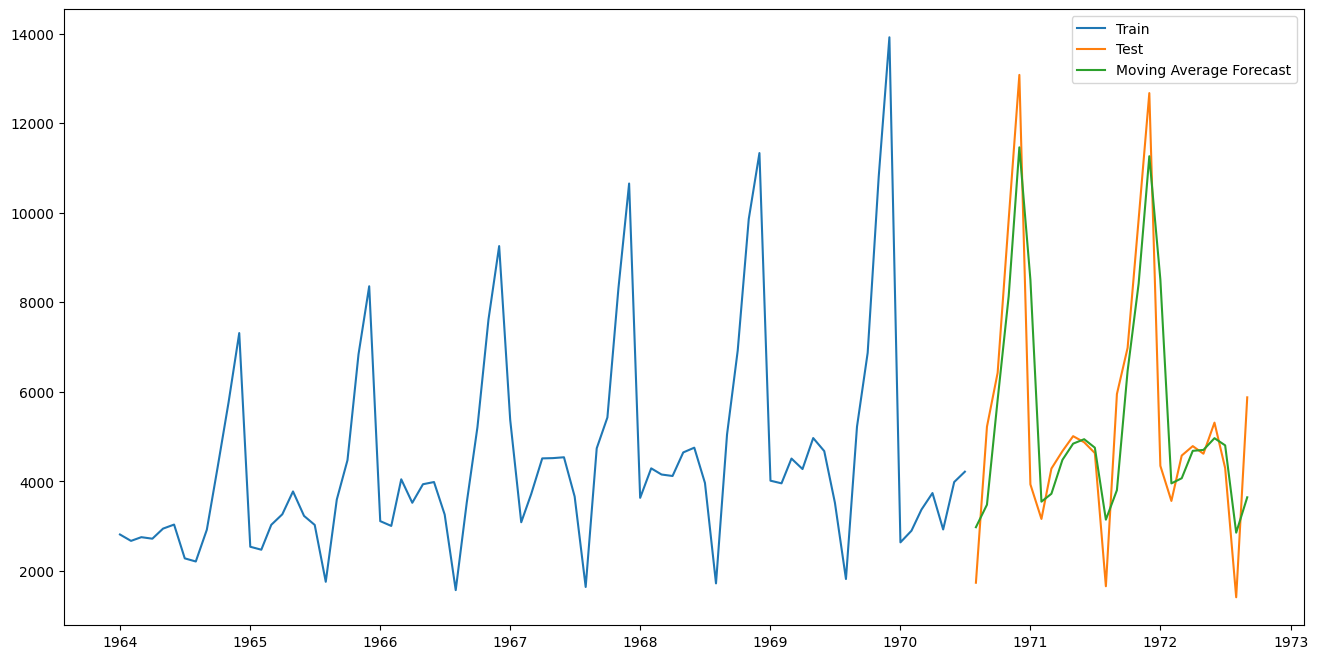

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg.moving_avg_forecast, label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
abs_error = np.abs(y_test['Sales']- y_hat_avg.moving_avg_forecast)
mape = np.round(np.mean(np.abs((actual - y_hat_avg.moving_avg_forecast) / actual)) * 100, 2)
print('RMSE: ', rmse)
print('MAPE: ', mape)

RMSE:  1619.8348681269952
MAPE:  28.3


Data Frame where all evaluation metrics will be appended

In [ ]:
resultsDf = pd.DataFrame({'Method':['Moving average forecast'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Moving average forecast,1619.834868,28.3


Exponential Smoothing

In [ ]:
model = smf.SimpleExpSmoothing(train['Sales'])

In [ ]:
for i in np.arange(0.1, 1, 0.1):
  model_fit = model.fit(smoothing_level = i, optimized = False)
  y_hat_avg = test.copy()
  y_hat_avg['SES'] = model_fit.forecast(len(test['Sales']))
  rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
  rmse = round(rmse, 2)
  abs_error = np.abs(y_test['Sales']- y_hat_avg.SES)
  actual = y_test['Sales']
  mape = np.round(np.mean(np.abs((actual - y_hat_avg.SES) / actual)) * 100, 2)
  print('Smoothing Level: ', np.round(i, 1), 'RMSE: ', rmse, 'MAPE: ', mape)

Smoothing Level:  0.1 RMSE:  2944.82 MAPE:  43.51
Smoothing Level:  0.2 RMSE:  3064.15 MAPE:  40.68
Smoothing Level:  0.3 RMSE:  3186.27 MAPE:  40.93
Smoothing Level:  0.4 RMSE:  3252.21 MAPE:  41.39
Smoothing Level:  0.5 RMSE:  3261.95 MAPE:  41.46
Smoothing Level:  0.6 RMSE:  3241.12 MAPE:  41.32
Smoothing Level:  0.7 RMSE:  3211.77 MAPE:  41.12
Smoothing Level:  0.8 RMSE:  3184.79 MAPE:  40.92
Smoothing Level:  0.9 RMSE:  3163.9 MAPE:  40.77


We choose 0.2 because of low MAPE and low RMSE

In [ ]:
model_fit = model.fit(smoothing_level = 0.2, optimized = False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': np.float64(2815.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
y_hat_avg = test.copy()

In [ ]:
y_hat_avg['SES'] = model_fit.forecast(len(test['Sales']))

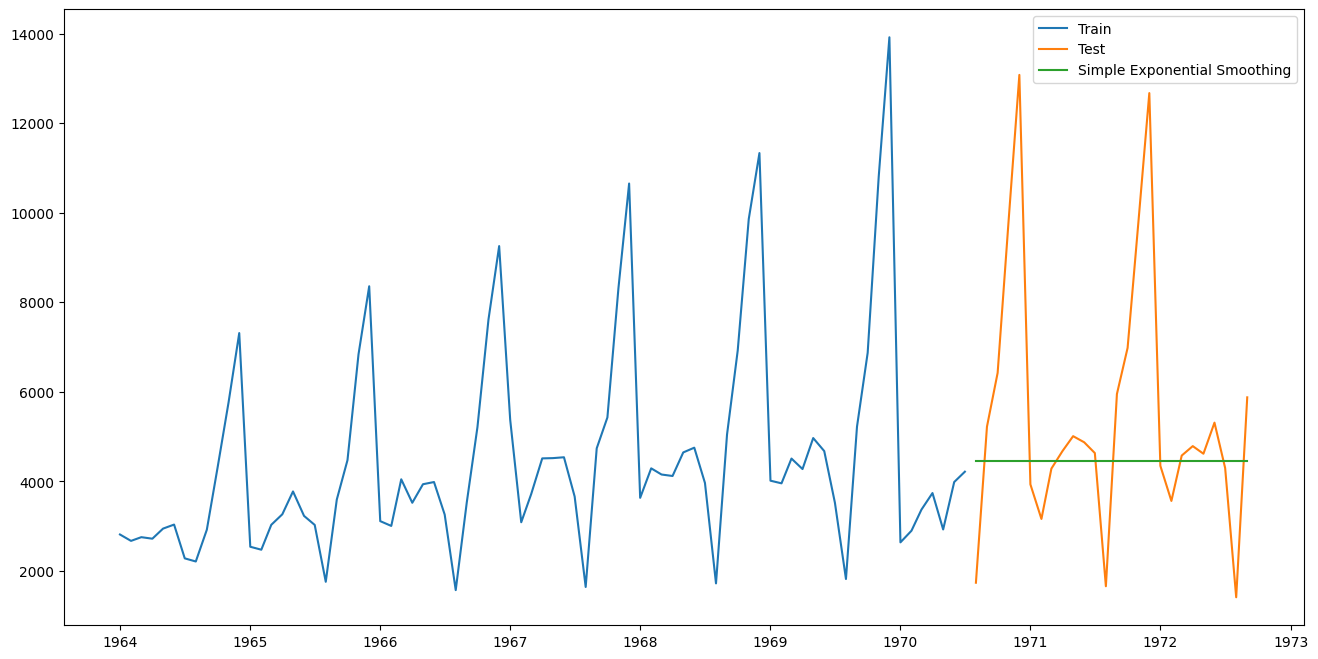

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['SES'], label='Simple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [ ]:
#RMSE
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
rmse = round(rmse, 2)

In [ ]:
#MAPE
abs_error = np.abs(y_test['Sales']-y_hat_avg.SES)
actual = y_test['Sales']
mape = np.round(np.mean(np.abs((actual - y_hat_avg.SES) / actual)) * 100, 2)

In [ ]:
tempResultsdf = pd.DataFrame({'Method':['Simple Exponential Smoothing'], 'MAPE': [mape], 'RMSE': [rmse]})
tempResultsdf = tempResultsdf[['Method', 'RMSE', 'MAPE']]
resultsDf = pd.concat([resultsDf, tempResultsdf])
resultsDf

,Method,RMSE,MAPE
0,Moving average forecast,1619.834868,28.30
0,Simple Exponential Smoothing,3064.150000,40.68
